<h1>Implementing SVM on Amazon fine food reviews dataset.</h1>

In [11]:
#Importing relevant libraries
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from prettytable import PrettyTable
from sklearn.model_selection import TimeSeriesSplit
import datetime as dt

<h3>Connecting to the preprocessed SQLITE database table</h3>

In [5]:
#Connecting to the SQL table
con = sqlite3.connect('final.sqlite')

#Reading data from the database

Data = pd.read_sql_query("""
SELECT *
FROM Reviews """,con)
Data.shape

# Drop index column
Data.drop(columns=['index'],inplace=True)


<h3>Processing the data for further use</h3>

In [12]:
#SETTING THE TIME COLUMN TO STANDARD DATE-TIME

Data['Time'] = Data[['Time']].applymap(lambda x: dt.datetime.fromtimestamp(x))

Data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08 05:30:00,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,2007-11-11 05:30:00,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,2007-10-04 05:30:00,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,2004-02-06 05:30:00,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,2002-04-10 05:30:00,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [13]:
#Setting Time column as index of the dataframe 
Data.set_index("Time",inplace=True)

#Sampling the above data

Sampled_data=Data.sample(n=30000,replace='False')
Sorted=Sampled_data.sort_index()

In [14]:
Sorted.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,CleanedText
Time,,,,,,,,,,
2000-06-03 05:30:00,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,positive,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,get crazi look beatlejuic french version video...
2000-12-19 05:30:00,374383,B00004CI84,A34NBH479RB0E,"""dmab6395""",0,1,positive,FUNNY,"I THOUGHT THIS MOVIE WAS SO FUNNY, MICHAEL KEA...",thought movi funni michael keaton beetlejuic r...
2001-06-11 05:30:00,451923,B00004CXX9,ANIMV3SPDD8SH,Guy De Federicis,1,12,negative,CASPER IS THE GHOST WITH THE MOST,Michael Keaton brings no distinguishing charac...,michael keaton bring distinguish characterist ...
2002-01-06 05:30:00,361317,B00005IX96,A3ODTU118FKC5J,Rosemarie E Smith,5,7,positive,A little piece of heaven.,For years I have been trying to simulate a tru...,year tri simul truli italian espresso cappucci...
2002-02-11 05:30:00,374420,B00004CI84,A1ZH086GZYL5MZ,Doug DeBolt,2,2,positive,"A little gross, a lot of fun",Michael Keaton was already on his way to being...,michael keaton alreadi way major star play gho...


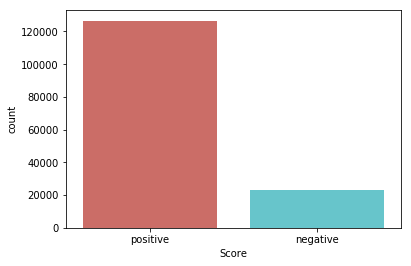

<Figure size 432x288 with 0 Axes>

In [15]:
Sorted=Sorted.drop_duplicates(subset={"UserId","ProfileName","Summary","Text"}, keep='first', inplace=False)

Full_data=Data.sample(n=150000,replace='False')
new_sample=Full_data.sort_index()

new_sample["Score"].value_counts()
#LABELS.value_counts()
LABELS=new_sample["Score"]
sns.countplot(x="Score",data=new_sample,palette="hls")
plt.show()
plt.savefig("count_plot")


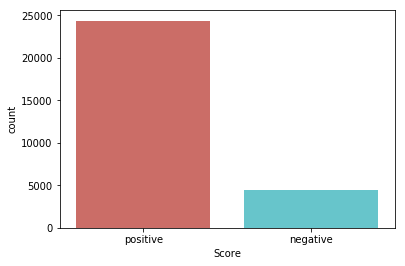

<Figure size 432x288 with 0 Axes>

In [16]:
polarity=Sorted["Score"]
sns.countplot(x="Score",data=Sorted,palette="hls")
plt.show()
plt.savefig("count_plot")


<h3>Splitting the data into 70:30 partitions sets</h3>

In [17]:
def data_split(x,y):
    #Splitting the model into 70:30 split of Training and Cross_validate split
    X_1, X_test, y_1, y_test = train_test_split(x, y, test_size=0.3,shuffle=False,random_state=None)

# split the train data set into cross validation train and cross validation test
    X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3,shuffle=False,random_state=None)
    
    return X_tr,y_tr,X_cv,y_cv,X_test,y_test

<h3>Preparing the data for further use</h3>

In [18]:
#PARTITIONING THE DATA FOR KERNEL SVMC
X=Sorted
Y=polarity

X_tr,y_tr,X_cv,y_cv,X_test,y_test=data_split(X,Y)

print("The shape of x_train is:",X_tr.shape)
print("the shape of y_train is:",y_tr.shape)
print("The shape of x_cval is:",X_cv.shape)
print("The shape of y_cval is:",y_cv.shape)
print("the shape of x_test is:",X_test.shape)
print("the shape of y_test is:",y_test.shape)

The shape of x_train is: (14110, 10)
the shape of y_train is: (14110,)
The shape of x_cval is: (6048, 10)
The shape of y_cval is: (6048,)
the shape of x_test is: (8640, 10)
the shape of y_test is: (8640,)


<h3>Partioining the data for the implementation of the Linear SVM</h3>

In [19]:

Linear_X=new_sample
Linear_Y=LABELS

li_xtr,li_ytr,li_xcv,li_ycv,li_xtest,li_ytest=data_split(Linear_X,Linear_Y)

print("The shape of x_train is:",li_xtr.shape)
print("the shape of y_train is:",li_ytr.shape)
print("The shape of x_cval is:",li_xcv.shape)
print("The shape of y_cval is:",li_ycv.shape)
print("the shape of x_test is:",li_xtest.shape)
print("the shape of y_test is:",li_ytest.shape)

The shape of x_train is: (73500, 10)
the shape of y_train is: (73500,)
The shape of x_cval is: (31500, 10)
The shape of y_cval is: (31500,)
the shape of x_test is: (45000, 10)
the shape of y_test is: (45000,)


<h3>Utility functions for training the models</h3>

In [20]:
#Function for training the data 
def train(X_tr, y_tr,X_cv,y_cv):
#Splitting the data into train and test set

    Model = SVC(class_weight="balanced") #Performing weight balancing technique due to class imbalance
    model = Model.fit(X_tr, y_tr)

    print("The model score on train set is= ", model.score(X_tr,y_tr))

    y_pred=model.predict(X_cv)

    acc = accuracy_score(y_cv, y_pred, normalize=True) * float(100)

    print('\nThe accuracy of SVM over cross_val set is =  %d%% ' % ( acc))
    
    return y_pred,acc
    
    
#Hyper-parameter tuning of SVM using Gridsearch technique

def Grid_s(X_train, y_train,X_cv,y_cv):
    
    Cs = [ 10 ** x for x in range(-5, 3)]
    gammas = [10 ** x for x in range(-5, 3)]
    
    #cv = TimeSeriesSplit(max_train_size=None, n_splits=3)

    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(class_weight= "balanced"), param_grid,scoring = 'accuracy', cv=3,n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("The best model parameters for Gridsearch technique is ",grid_search.best_params_)
    print("The model score over the cv set is ",grid_search.score(X_cv,y_cv))
    return grid_search.best_params_

#Function for doing random search
def Random_s(X_train, y_train,X_cv,y_cv):    

    from scipy.stats import uniform
    from sklearn.model_selection import RandomizedSearchCV
    cv = TimeSeriesSplit(max_train_size=None, n_splits=3)

    C = uniform(loc=0, scale=2)
    gammas=uniform(loc=0,scale=2)

    param_grid={"C":C,"gamma":gammas}

    model1 =  RandomizedSearchCV(SVC(class_weight="balanced"), param_grid,scoring = 'accuracy',n_jobs=-1, cv=cv)
    model1.fit(X_train, y_train)

    print("The best model parameters for Randomsearch technique is ",model1.best_params_)
    print("The model score over the cv set is ",model1.score(X_cv, y_cv))
    return model1.best_params_
    

#Function for finding the test accuracy by using the default alpha   
def tuned_test(X_tr,y_tr,X_test,y_test,c,gam):

    New_clf= SVC(C=c,gamma=gam,class_weight="balanced")

    new_model=New_clf.fit(X_tr,y_tr)

    print("The model score on train set is= ", new_model.score(X_tr,y_tr))

    Y_pred=new_model.predict(X_test)

    new_acc = accuracy_score(y_test, Y_pred, normalize=True) * float(100)

    print('\nThe accuracy of svm over Test set is =  %d%% ' % ( new_acc))


    
    return Y_pred,new_acc





<h2> Common Utility functions for plotting the results</h2>

In [21]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the cv and training learning curve.

       """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<h2>Utility functions for plotting the confusion matrix </h2>

In [22]:
from sklearn.metrics import confusion_matrix
def Confusion_metric(y_test,y_pred,acc):
    print(metrics.confusion_matrix(y_test,y_pred))
    confusion=metrics.confusion_matrix(y_test,y_pred)

    plt.figure(figsize=(9,9))
    sns.heatmap(confusion, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Predicted label');
    plt.xlabel('Actual label');
    all_sample_title = 'Accuracy Score: {0}'.format( acc)
    plt.title(all_sample_title, size = 15);
    plt.show()

#Storing the values of the confusion matrix
    TN=confusion[0,0]
    FP=confusion[0,1]
    FN=confusion[1,0]
    TP=confusion[1,1]

# use float to perform true division, not integer division
    Class_acc=((TP + TN) / float(TP + TN + FP + FN))*100

#Code for classification error

    classification_error = ((FP + FN) / float(TP + TN + FP + FN))*100
    

#Code for finding the TPR,FPR,TNR,FNR

    TPR = (TP / float(FN + TP))*100

    FNR = (FN / float(FN + TP))*100

    TNR=(TN / float(TN + FP))*100

    FPR=(FP / float(TN + FP))*100
    
#Code for finding the Precision,Recall & F1_score    
   
    precision = (TP/float(TP+FP))*100
    
    recall= (TP / float(FN + TP))*100
    
    F1_s= ((float(precision*recall)/float(precision+recall))*2)
    
    print()
    
    ptable=PrettyTable()
    ptable.title="The performance metrics of the above model are as follows: "
    ptable.field_names=["Metrics","Scores"]
    ptable.add_row(["Classification_accuracy",Class_acc])
    ptable.add_row(["Classification_error",classification_error])
    ptable.add_row(["True positive",TP])
    ptable.add_row(["False positive",FP])
    ptable.add_row(["True negative",TN])
    ptable.add_row(["False negative",FN])
    ptable.add_row(["True positive rate",TPR])
    ptable.add_row(["False negative rate",FNR])
    ptable.add_row(["True negative rate",TNR])
    ptable.add_row(["False positive rate",FPR])
    ptable.add_row(["Precision value",precision])
    ptable.add_row(["Recall value",recall])
    ptable.add_row(["f1_score value",F1_s])
    
    print(ptable)
    

In [65]:

def conclusion_table():
    print()
    ptable=PrettyTable()
    ptable.title="The comparisons of all the vectorizers are as follows: "
    ptable.field_names=["Vectorizer","Algorithm","Scores","Status"]
    ptable.add_row(["Bag-Of-Words","Kernel-SVM","86.6% ","Stable"])
    ptable.add_row(["Bag-Of-Words","Linear-SVM","92.87%" ,"Stable"])
    ptable.add_row(["Tf-IDF","Kernel-SVM","88.33%" ,"Stable"])
    ptable.add_row(["Tf-IDF","Linear-SVM","89.82%" ,"Unstable"])
    ptable.add_row(["Average-word2vec","Kernel-SVM","85.91%" ,"Unstable"])
    ptable.add_row(["Average-word2vec","Linear-SVM","88.05%" ,"Unstable"])
    ptable.add_row(["TF-IDF-Weighted-word2vec","Kernel-SVM","84.67%" ,"Unstable"])
    ptable.add_row(["TF-IDF-Weighted-word2vec","Linear-SVM", "85.94%","Unstable"])
   
    print(ptable)
    
    

<h3>Utilty functions for vectorizing the data</h3>

In [24]:
#Function for vectorizing the train data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler(with_mean=False)


def vec_train(vect,X_tr):
    import warnings
    warnings.filterwarnings("ignore")

    count_vect = vect #in scikit-learn
    BOW = count_vect.fit_transform(X_tr.values)

#Standardizing the vectorized data
    standardized_data = scaler.fit_transform(BOW)
    standardized_data.shape
    return count_vect,standardized_data


#Function for vectorizing the CV data

def vec_cv(count,X_cv):
    cv=count.transform(X_cv.values)
    cv.get_shape()

    std_cv=scaler.transform(cv)
    std_cv.shape
    return std_cv


#Function for vectorizing the test data

def vec_test(count,X_test):
    test=count.transform(X_test.values)
    test.get_shape()

    std_data=scaler.transform(test)
    std_data.shape
    return std_data

#Funtion for printing the total number of top features
def top_tfidf_feats(name,row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', name]
    return df

#Function for displaying top frequent 50 tokens distributions 
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer
def display_token(Vect,data):

    vectorizer = Vect
    docs       = vectorizer.fit_transform(data)
    features   = vectorizer.get_feature_names()
    
    visualizer = FreqDistVisualizer(features=features)
    visualizer.fit(docs)
    visualizer.poof()







<h2>Implementing the Bag of words vectorization technique</h2>

In [25]:
#Initializing the count vectorizer 
Count_vect=CountVectorizer()

#vectorizing the X_train set
count,x_tr=vec_train(Count_vect,X_tr["CleanedText"])

print("The shape of the X_train is: ",x_tr.shape)

#Vectgorizing the X_crossvalidation set
x_cv=vec_cv(count,X_cv["CleanedText"])
print("The shape of the X_cv is: ",x_cv.shape)


#Vectorizing the X_test set
x_test=vec_test(count,X_test["CleanedText"])
print("The shape of the X_test is: ",x_test.shape)


#Printing the total length of the features
print("\nTop 25 feaures acording to the Bow score are as follows")
features = Count_vect.get_feature_names()
len(features)


top_Bow = top_tfidf_feats("bow",x_tr[1,:].toarray()[0],features,25)
top_Bow




The shape of the X_train is:  (14110, 15155)
The shape of the X_cv is:  (6048, 15155)
The shape of the X_test is:  (8640, 15155)

Top 25 feaures acording to the Bow score are as follows


,feature,bow
0,geeki,118.789730
1,scenc,118.789730
2,priceless,68.588144
3,alec,53.131915
4,baldwin,48.504300
5,keaton,42.003722
6,michael,30.686605
7,beetlejuic,19.800394
8,funni,15.363626
9,play,11.058850


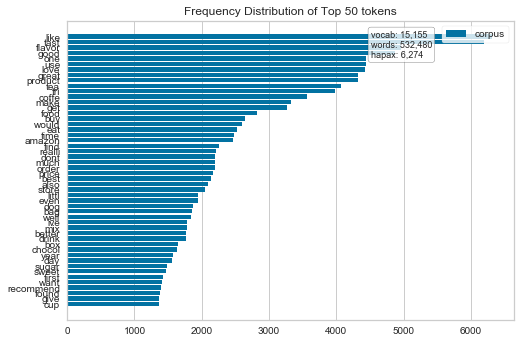

In [26]:
display_token(Count_vect,X_tr["CleanedText"])

<h2>Training the model over the BOW vectorized data</h2>

In [19]:
%%time
pred,acc=train(x_tr,y_tr,x_cv,y_cv)


The model score on train set is=  0.9806802721088436

The accuracy of SVM over cross_val set is =  87% 
Wall time: 3min 21s


[[ 470  661]
 [ 146 5023]]


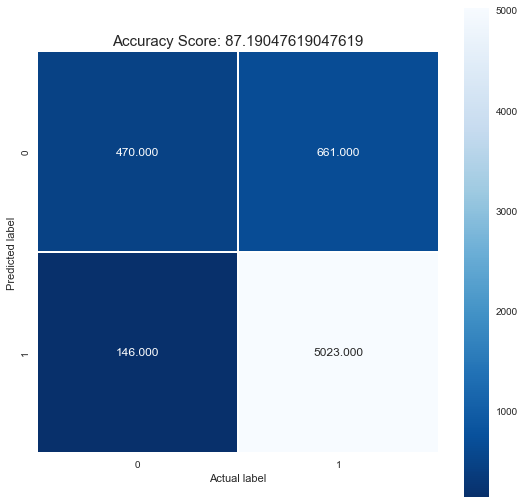


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+----------------------------------+--------------------------+
|             Metrics              |          Scores          |
+----------------------------------+--------------------------+
|     Classification_accuracy      |    87.19047619047619     |
|       Classification_error       |    12.80952380952381     |
|          True positive           |           5023           |
|          False positive          |           661            |
|          True negative           |           470            |
|          False negative          |           146            |
|        True positive rate        |     97.1754691429677     |
|       False negative rate        |    2.824530857032308     |
|        True negative rate        |    41.55614500442087     |
|       False positive rate        |    58.44385499557914     |
|         Precision value          |   

In [20]:
Confusion_metric(y_cv,pred,acc)

<h3>Observation</h3>
<ul>
    <li>The train accuracy of the model over Bag-of-words vectorized data is 87.19% by using the default parameters.</li>
    <li>The performance metrics of the above model is not good as the True-positives rate are very high as compared to all other metrics so the model is not stable.</li>
    <li>The False positive rate is around 58.44% which is very high as compared to the False negative rate which is not good for a model.</li>
    <li>So the model has a bias problem which is affecting the model a lot and can be solved by tuning the hyperparameter.</li>
   </ul>

<h3>Tuning the hyperparameters by performing the Gridsearch and Randomsearch technique.</h3>

In [21]:
%%time

#CODE FOR FINDING THE BEST HYPERPARAMETERS THROUGH GRIDSEARCH

Best_param=Grid_s(x_tr,y_tr,x_cv,y_cv)




The best model parameters for Gridsearch technique is  {'C': 10, 'gamma': 1e-05}
The model score over the cv set is  0.8846031746031746
Wall time: 41min 4s


<h3>Implementing the Randomsearch technique</h3> 

In [22]:

%%time
#CODE FOR FINDING THE BEST HYPERPARAMETERS USING RANDOMSEARCH
Random_param=Random_s(x_tr,y_tr,x_cv,y_cv)




The best model parameters for Randomsearch technique is  {'C': 0.6591632021221285, 'gamma': 1.7712275027341886}
The model score over the cv set is  0.8204761904761905
Wall time: 14min 24s


<h3>Testing the model over the test set using the optimal hyperparameters</h3>

In [23]:
Y_pred,new_acc=tuned_test(x_tr,y_tr,x_test,y_test,c=10,gam=1e-05)

The model score on train set is=  0.9821768707482993

The accuracy of svm over Test set is =  86% 


<h3>Confusion matrix of the above model</h3>

[[ 903  726]
 [ 480 6891]]


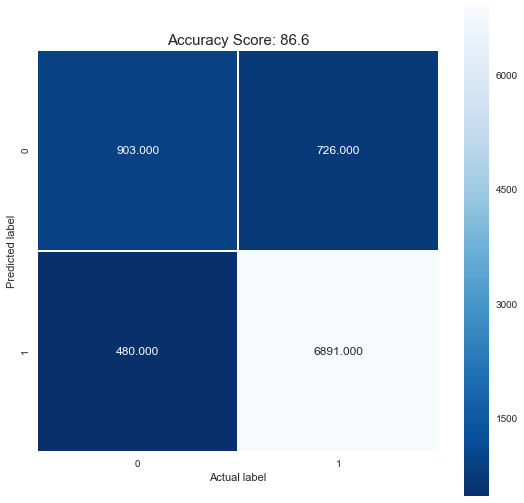


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |            86.6           |
|       Classification_error      |            13.4           |
|          True positive          |            6891           |
|          False positive         |            726            |
|          True negative          |            903            |
|          False negative         |            480            |
|        True positive rate       |     93.48799348799349     |
|       False negative rate       |     6.512006512006511     |
|        True negative rate       |     55.432780847145494    |
|       False positive rate       |     44.56721915285451     |
|         Precision value         |    

In [24]:
Confusion_metric(y_test,Y_pred,new_acc)

<h3>Observations</h3>
<ul>
    <li>After tuning the hyperparameters the test accuracy of the model is 86.6% which is quite good for a model.</li>
    <li>Here also the True positive rates are dominating and affecting the other parametrs a lot.</li>
    <li>The False positive rate is very high and alarming which is not good for a model.</li>
    <li>There is still bias problems in the model so the accuracy cannot be trusted blindly.</li>
    

In [32]:
Count_vect=CountVectorizer()

#vectorizing the X_train set
count,li_tr=vec_train(Count_vect,li_xtr["CleanedText"])

print("The shape of the X_train is: ",li_tr.shape)

#Vectgorizing the X_crossvalidation set
li_cv=vec_cv(count,li_xcv["CleanedText"])
print("The shape of the X_cv is: ",li_cv.shape)


#Vectorizing the X_test set
li_test=vec_test(count,li_xtest["CleanedText"])
print("The shape of the X_test is: ",li_test.shape)



The shape of the X_train is:  (73500, 29744)
The shape of the X_cv is:  (31500, 29744)
The shape of the X_test is:  (45000, 29744)


<h2>Implementing Linear SVM by using the SGD algorithm</h2>

In [60]:
#FUNCTION FOR PERFORMING CROSS-VALIDATION

from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
def Cv_results(X_cv, y_cv):
    cv_erro_array1 = []
    
    alpha = [10 ** x for x in range(-2, 5)]
    for a in alpha:
        print("--------------------------------------------------------------------------------------------------------")
        print("for alpha =", a)
        clf = SGDClassifier(alpha=a, penalty='l1', loss='hinge', random_state=42)
        Scores = cross_val_score(clf, X_cv, y_cv, cv=10,scoring='accuracy')
        cv_erro_array1.append(Scores.mean())
    
        mse1=[1- x for x in cv_erro_array1]
        # determining best alpha
        #Best_alpha = alpha[mse.index(min(mse))]
        print("\nthe misclassification error for each alpha value is : ", np.round(mse1,3))
        #print("\nthe 10-fold CV_accuracy for each alpha is :",Scores)
        
    fig, ax = plt.subplots()
    ax.plot(alpha,mse1,c='g')
    for i, txt in enumerate(np.round(mse1,3)):
        ax.annotate((alpha[i],str(txt)), (alpha[i],mse1[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

    Best_alpha = np.round(alpha[mse1.index(min(mse1))])
    

<h3>Tuning the hyperaprametrs by doing the 10k-fold Crossvalidation technique</h3>

--------------------------------------------------------------------------------------------------------
for alpha = 0.01

the misclassification error for each alpha value is :  [0.153]
--------------------------------------------------------------------------------------------------------
for alpha = 0.1

the misclassification error for each alpha value is :  [0.153 0.145]
--------------------------------------------------------------------------------------------------------
for alpha = 1

the misclassification error for each alpha value is :  [0.153 0.145 0.139]
--------------------------------------------------------------------------------------------------------
for alpha = 10

the misclassification error for each alpha value is :  [0.153 0.145 0.139 0.139]
--------------------------------------------------------------------------------------------------------
for alpha = 100

the misclassification error for each alpha value is :  [0.153 0.145 0.139 0.139 0.139]
-----------------

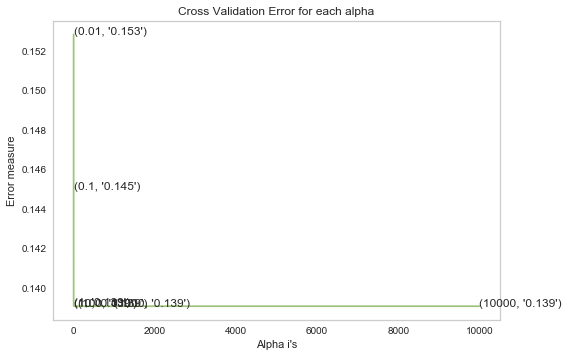

In [61]:
Cv_results(li_tr,li_ytr)

<h3>Utility function for training the Linear SVM</h3>

In [29]:
def linearsvm (x_test,y_test,a):
    
    clf = linear_model.SGDClassifier(loss="hinge",alpha=a,max_iter=1000)
    clf.fit(x_test,y_test)

    sgd_y=clf.predict(x_test)

    sgd_acc = accuracy_score(y_test, sgd_y, normalize=True) * float(100)

    print('\nThe accuracy of svm over Test set is =  %d%% ' % ( sgd_acc))
    return sgd_y,sgd_acc

<h3>Testing the above model over the test set.</h3>

In [62]:
sgd_y,sgd_acc=linearsvm(li_test,li_ytest,1)


The accuracy of svm over Test set is =  92% 


[[ 4829  3020]
 [  209 36942]]


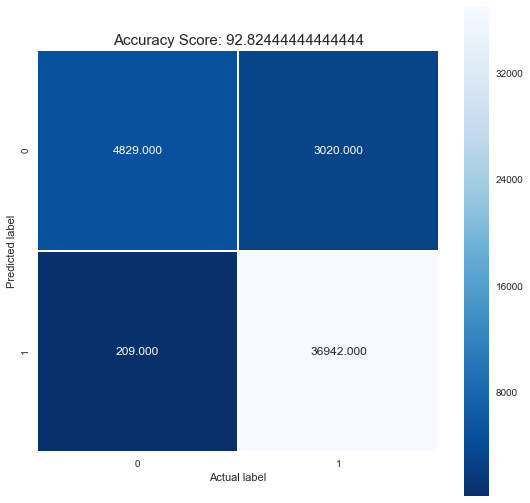


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     92.82444444444444     |
|       Classification_error      |     7.1755555555555555    |
|          True positive          |           36942           |
|          False positive         |            3020           |
|          True negative          |            4829           |
|          False negative         |            209            |
|        True positive rate       |      99.4374310247369     |
|       False negative rate       |     0.5625689752631154    |
|        True negative rate       |     61.52376098866098     |
|       False positive rate       |     38.476239011339025    |
|         Precision value         |    

In [63]:
Confusion_metric(li_ytest,sgd_y,sgd_acc)

<h3>Observation</h3>
<ul>
    <li>The test accuracy of the linear model is 92.82% which is excellent for a classification model.</li>
    <li>The Diagonal elements of the confusion matrix are very high as compared to the non-diagonal ones so the model is doing a good job of classifying the positive and negative reviews.</li>
    <li>The False positive rate is significant around 38.47% which is quite alarming 
    <li>So linear SVM works well over the Bag-of-word vectorized text data.</li> 

<h2>Implementing the Tf-idf vectorization.</h2>

In [29]:
#Initializing the count vectorizer 
TFIDF_vect=TfidfVectorizer(ngram_range=(1,2),min_df=5)

#vectorizing the X_train set
TF,tfx_tr=vec_train(TFIDF_vect,X_tr["CleanedText"])

print("The shape of the X_train is: ",tfx_tr.shape)

#Vectgorizing the X_crossvalidation set
tfx_cv=vec_cv(TF,X_cv["CleanedText"])
print("The shape of the X_cv is: ",tfx_cv.shape)

#Vectorizing the X_test set
tfx_test=vec_test(TF,X_test["CleanedText"])
print("The shape of the X_test is: ",tfx_test.shape)


#Printing the total length of the features
print("\nTop 25 feaures acording to the TF-IDF score are as follows")
TF_features = TFIDF_vect.get_feature_names()
len(TF_features)


top_TFIDF = top_tfidf_feats("TFIDF",tfx_tr[1,:].toarray()[0],TF_features,25)
top_TFIDF



The shape of the X_train is:  (14700, 19728)
The shape of the X_cv is:  (6300, 19728)
The shape of the X_test is:  (9000, 19728)

Top 25 feaures acording to the TF-IDF score are as follows


,feature,TFIDF
0,know well,65.648498
1,fact like,61.357330
2,well known,59.406576
3,hey,51.134875
4,like see,46.112671
5,tri see,43.288227
6,danc,29.928701
7,film,27.479313
8,shown,23.619785
9,movi,20.884362


<h2>Training the model by using the default parameters.</h2>

In [30]:
Pred,Acc=train(tfx_tr,y_tr,tfx_cv,y_cv)

The model score on train set is=  0.9998639455782313

The accuracy of SVM over cross_val set is =  86% 


[[ 297  834]
 [  38 5131]]


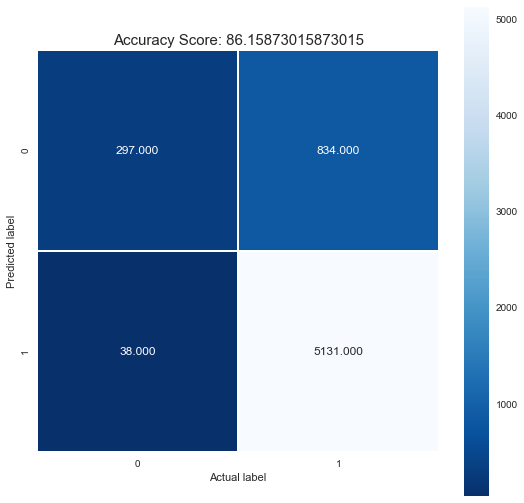


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     86.15873015873015     |
|       Classification_error      |     13.84126984126984     |
|          True positive          |            5131           |
|          False positive         |            834            |
|          True negative          |            297            |
|          False negative         |             38            |
|        True positive rate       |     99.26484813310118     |
|       False negative rate       |     0.7351518668988198    |
|        True negative rate       |     26.25994694960212     |
|       False positive rate       |     73.74005305039788     |
|         Precision value         |    

In [31]:
Confusion_metric(y_cv,Pred,Acc)

<h3>Observations</h3>
<ul>
    <li>The performance metrics of the model is not that good which can be seen by the Confusion matrix scores.</li>
    <li>So the model's performance can be improved by tuning the hyperparameters.</li>


<h3>Tuning the Hyperaparameters by using the GridSearchCV and RandomsearchCV techniques</h3>

In [32]:
%%time

#CODE FOR FINDING THE BEST HYPERPARAMETERS THROUGH GRIDSEARCH

Best_para=Grid_s(tfx_tr,y_tr,tfx_cv,y_cv)




The best model parameters for Gridsearch technique is  {'C': 1, 'gamma': 1e-05}
The model score over the cv set is  0.8917460317460317
Wall time: 50min 31s


<h3>Randomsearch techniques</h3>

In [33]:

%%time
#CODE FOR FINDING THE BEST HYPERPARAMETERS USING RANDOMSEARCH
Random_para=Random_s(tfx_tr,y_tr,tfx_cv,y_cv)




The best model parameters for Randomsearch technique is  {'C': 1.2897118382010795, 'gamma': 1.9764638888738673}
The model score over the cv set is  0.8204761904761905
Wall time: 16min 6s


<h3>Testing the model by using the optimal hyperaprameters.</h3>

In [35]:
Y_Pred,new_accU=tuned_test(tfx_tr,y_tr,tfx_test,y_test,c=1,gam= 1e-05)

The model score on train set is=  0.9825850340136054

The accuracy of svm over Test set is =  88% 


<h3>Confusion matrix of the above model.</h3>

[[ 636  403]
 [ 297 4664]]


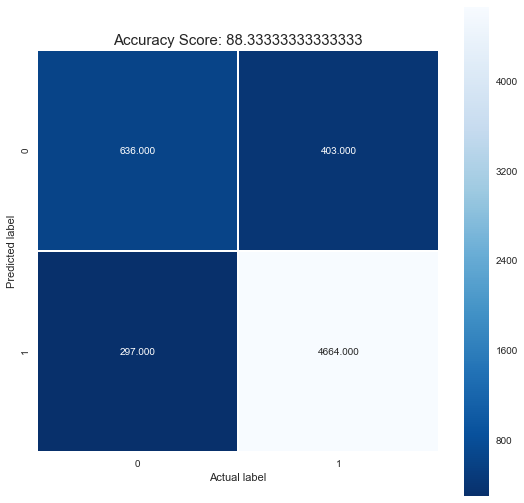


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     88.33333333333333     |
|       Classification_error      |     11.666666666666666    |
|          True positive          |            4664           |
|          False positive         |            403            |
|          True negative          |            636            |
|          False negative         |            297            |
|        True positive rate       |     94.01330376940133     |
|       False negative rate       |     5.986696230598669     |
|        True negative rate       |     61.21270452358036     |
|       False positive rate       |     38.78729547641964     |
|         Precision value         |    

In [35]:
Confusion_metric(y_test,Y_Pred,new_accU)

<h3>Observations</h3>
<ul>
    <li>The test accuracy of the model is 88.33% by using the optimal hyperparameters which is good for a model.</li>
    <li>The True-postive-rate and the True-Negative-rate are very good as compared to the metrics.</li>
    <li>The false rates are quite low and the model is sensible in classifying the reviews properly.</li>

In [40]:
#Initializing the count vectorizer 
TFIDF_vect=TfidfVectorizer(ngram_range=(1,2),min_df=5)

#vectorizing the X_train set
lin,lin_tr=vec_train(TFIDF_vect,li_xtr["CleanedText"])

print("The shape of the X_train is: ",lin_tr.shape)

#Vectgorizing the X_crossvalidation set
lin_cv=vec_cv(lin,li_xcv["CleanedText"])
print("The shape of the X_cv is: ",lin_cv.shape)

#Vectorizing the X_test set
lin_test=vec_test(lin,li_xtest["CleanedText"])
print("The shape of the X_test is: ",lin_test.shape)



The shape of the X_train is:  (73500, 102734)
The shape of the X_cv is:  (31500, 102734)
The shape of the X_test is:  (45000, 102734)


<h2> Implementing the Linear SVM model and performing 10k-Crossvalidation over it.</h2>

--------------------------------------------------------------------------------------------------------
for alpha = 0.01

the misclassification error for each alpha value is :  [0.173]
--------------------------------------------------------------------------------------------------------
for alpha = 0.1

the misclassification error for each alpha value is :  [0.173 0.157]
--------------------------------------------------------------------------------------------------------
for alpha = 1

the misclassification error for each alpha value is :  [0.173 0.157 0.14 ]
--------------------------------------------------------------------------------------------------------
for alpha = 10

the misclassification error for each alpha value is :  [0.173 0.157 0.14  0.139]
--------------------------------------------------------------------------------------------------------
for alpha = 100

the misclassification error for each alpha value is :  [0.173 0.157 0.14  0.139 0.139]
-----------------

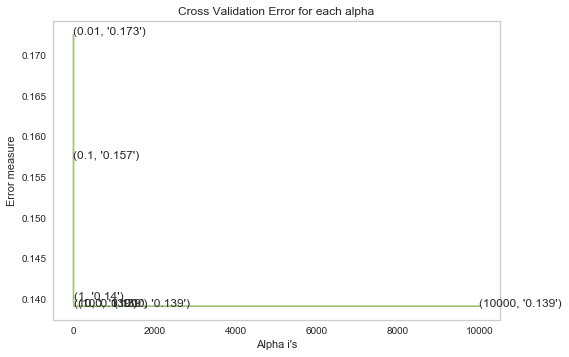

In [64]:
Cv_results(lin_tr,li_ytr)

<h3>Testing the linear model over the test set</h3> 

In [58]:
TF_sgd_y,TF_sgd_acc=linearsvm(lin_test,li_ytest,10)


The accuracy of svm over Test set is =  89% 


[[ 3222  4627]
 [    9 37142]]


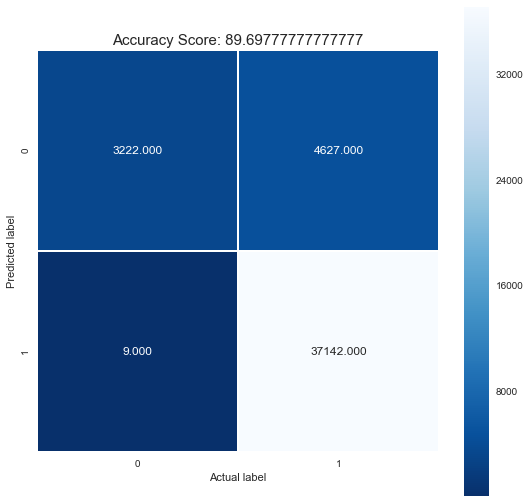


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+--------------------------------+----------------------------+
|            Metrics             |           Scores           |
+--------------------------------+----------------------------+
|    Classification_accuracy     |     89.69777777777777      |
|      Classification_error      |     10.302222222222222     |
|         True positive          |           37142            |
|         False positive         |            4627            |
|         True negative          |            3222            |
|         False negative         |             9              |
|       True positive rate       |     99.97577454173509      |
|      False negative rate       |    0.024225458264918846    |
|       True negative rate       |     41.049815263090835     |
|      False positive rate       |     58.950184736909165     |
|        Precision value         |     

In [59]:
Confusion_metric(li_ytest,TF_sgd_y,TF_sgd_acc)

<h2>Implementing the Average-word2vec-Vectorization techniques.</h2>

In [100]:
#code for finding the average word2vec

#Utility function for implementing the Average-word2vec-vectorization techniques

import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors

def Average_word2Vec (X_tr,X_test):
    
# Train our own Word2Vec model using text corpus
    Train_sentence_list=[]
    for sentence in X_tr:
        Train_sentence_list.append(sentence.split())
    
    Test_sentence_list=[]
    for sentence in X_test:
        Test_sentence_list.append(sentence.split())
   
    print("length of train list set is as follows: ",len(Train_sentence_list))
    print("length of test list set is as follows : ",len(Test_sentence_list))
    print("*"*100)

# Generate model and train our model on train data
    w2v_model=w2v_model_train =gensim.models.Word2Vec(Train_sentence_list,min_count=5,size=50, workers=6)

    # List of word in vocabulary 
    w2v_words = list(w2v_model_train.wv.vocab)
    print("length of the W2v vocabulary is : ",len(w2v_words))

#Finding the average word2vec over the train set
    train_list = []
    for sentence in Train_sentence_list:
        word_2_vec = np.zeros(50)
        cnt_words = 0
        for word in sentence:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                word_2_vec += vec
                cnt_words += 1
        if cnt_words != 0 :
            word_2_vec /= cnt_words
        train_list.append(word_2_vec)
    
 #Finding the average word2vec over the test set    
    test_list = []
    for sentence in Test_sentence_list:
        word_2_vec = np.zeros(50)
        cnt_words = 0
        for word in sentence:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                word_2_vec += vec
                cnt_words += 1
        if cnt_words != 0 :
            word_2_vec /= cnt_words
        test_list.append(word_2_vec)
    
    
    print("The size of the trained average word2vec is :",len(train_list))
    print("The dimensions of average word2vec is :",len(train_list[0]))
    print()
    print("The size of the test average word2vec is :",len(test_list))
    print("The dimensions of the test average word2vec is :",len(test_list[0]))
    
    return Train_sentence_list,Test_sentence_list,w2v_model,w2v_words,train_list,test_list




<h3>Preparing the data over the Average-word2vectorized data</h3>

In [101]:
Train=X_tr["CleanedText"]
Test=X_test["CleanedText"]

tr_list,tes_list,model,words,trw2v,testw2v=Average_word2Vec(Train,Test)

length of train list set is as follows:  14700
length of test list set is as follows :  9000
****************************************************************************************************
length of the W2v vocabulary is :  5446
The size of the trained average word2vec is : 14700
The dimensions of average word2vec is : 50

The size of the test average word2vec is : 9000
The dimensions of the test average word2vec is : 50


<h3>Training the model over the vectorized data by using default parameters</h3>

In [21]:
%%time
w2v_pred,w2v_acc=train(trw2v,y_tr,testw2v,y_test)

The model score on train set is=  0.8202721088435374

The accuracy of SVM over cross_val set is =  80% 
Wall time: 17 s


[[1303  223]
 [1562 5912]]


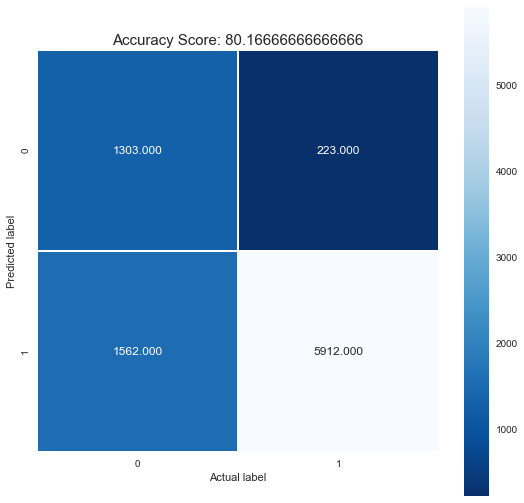


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     80.16666666666666     |
|       Classification_error      |     19.833333333333332    |
|          True positive          |            5912           |
|          False positive         |            223            |
|          True negative          |            1303           |
|          False negative         |            1562           |
|        True positive rate       |      79.1008830612791     |
|       False negative rate       |     20.899116938720898    |
|        True negative rate       |     85.38663171690695     |
|       False positive rate       |     14.613368283093052    |
|         Precision value         |    

In [23]:
Confusion_metric(y_test,w2v_pred,w2v_acc)

<h3>Tuning the Hyper-parameters for finding the right alpha and gamma</h3>

In [24]:
%%time

#CODE FOR FINDING THE BEST HYPERPARAMETERS THROUGH GRIDSEARCH

w2v_para=Grid_s(trw2v,y_tr,testw2v,y_test)


The best model parameters for Gridsearch technique is  {'C': 1, 'gamma': 1}
The model score over the cv set is  0.8436666666666667
Wall time: 10min 27s


In [25]:

%%time
#CODE FOR FINDING THE BEST HYPERPARAMETERS USING RANDOMSEARCH
Randw2v_para=Random_s(trw2v,y_tr,testw2v,y_test)




The best model parameters for Randomsearch technique is  {'C': 1.1698528631164136, 'gamma': 0.6067514452686538}
The model score over the cv set is  0.8591111111111112
Wall time: 2min 22s


<h3>Testing the model over the test set using the optimal hyperaparameters</h3>

In [26]:
W2V_Pred,W2V_accu=tuned_test(trw2v,y_tr,testw2v,y_test,c=1.1698528631164136,gam= 0.6067514452686538)

The model score on train set is=  0.9912244897959184

The accuracy of svm over Test set is =  85% 


[[ 608  918]
 [ 350 7124]]


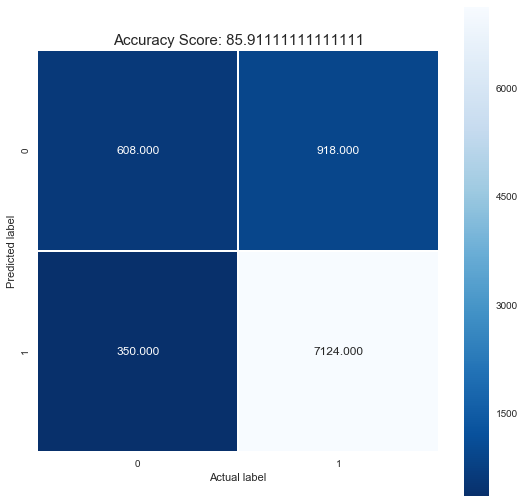


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+----------------------------------+--------------------------+
|             Metrics              |          Scores          |
+----------------------------------+--------------------------+
|     Classification_accuracy      |    85.91111111111111     |
|       Classification_error       |    14.08888888888889     |
|          True positive           |           7124           |
|          False positive          |           918            |
|          True negative           |           608            |
|          False negative          |           350            |
|        True positive rate        |    95.31709927749532     |
|       False negative rate        |    4.682900722504683     |
|        True negative rate        |    39.84272608125819     |
|       False positive rate        |    60.15727391874181     |
|         Precision value          |   

In [27]:
Confusion_metric(y_test,W2V_Pred,W2V_accu)

<h3>Observations</h3>
<ul>
    <li>The test accuracy of the Kernel SVM model is 85.91% but it is miss-leading because after studying the confusion-matrix the model is not sensible.</li>
    <li>There is a serious bias problem as the majority points which are the positive reviews are dominating which leads to poor classiffication of the negative reviews.</li>
    <li>So here the Kernel SVM model fails to classify the reviews properly.</li>
    <li>Let's try the Linear SVM model for better accuracies.</li>

<h2>Implementing the Average word-2-vec over the 150k datapoints</h2>

In [102]:
Train_sgd=li_xtr["CleanedText"]
Test_sgd=li_xtest["CleanedText"]

Tr_list,Tes_list,Model,Words,Trw2v,Testw2v=Average_word2Vec(Train_sgd,Test_sgd)

length of train list set is as follows:  73500
length of test list set is as follows :  45000
****************************************************************************************************
length of the W2v vocabulary is :  11148
The size of the trained average word2vec is : 73500
The dimensions of average word2vec is : 50

The size of the test average word2vec is : 45000
The dimensions of the test average word2vec is : 50


<h3> Implementing the Linear SVM model and performing 10k-Crossvalidation over it.</h3>

--------------------------------------------------------------------------------------------------------
for alpha = 1e-05

the misclassification error for each alpha value is :  [0.174]
--------------------------------------------------------------------------------------------------------
for alpha = 0.0001

the misclassification error for each alpha value is :  [0.174 0.12 ]
--------------------------------------------------------------------------------------------------------
for alpha = 0.001

the misclassification error for each alpha value is :  [0.174 0.12  0.11 ]
--------------------------------------------------------------------------------------------------------
for alpha = 0.01

the misclassification error for each alpha value is :  [0.174 0.12  0.11  0.143]
--------------------------------------------------------------------------------------------------------
for alpha = 0.1

the misclassification error for each alpha value is :  [0.174 0.12  0.11  0.143 0.143]
-------

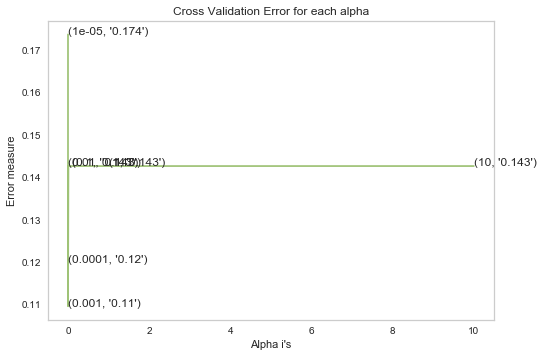

In [103]:
Cv_results(Trw2v,li_ytr)

<h3>Testing the linear model over the test set</h3> 

In [104]:
w2v_sgd_y,w2v_sgd_acc=linearsvm(Testw2v,li_ytest,0.001)


The accuracy of svm over Test set is =  88% 


[[ 707  819]
 [ 256 7218]]


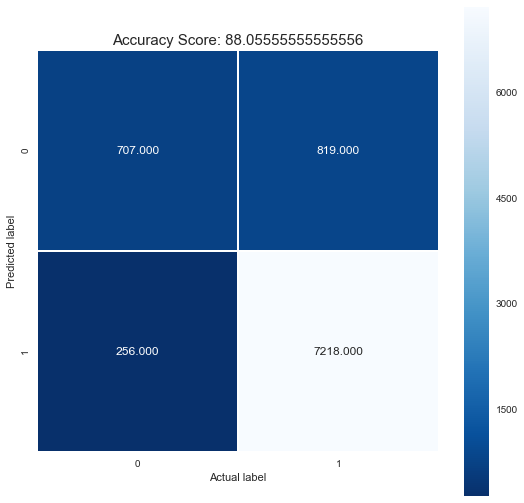


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     88.05555555555556     |
|       Classification_error      |     11.944444444444445    |
|          True positive          |            7218           |
|          False positive         |            819            |
|          True negative          |            707            |
|          False negative         |            256            |
|        True positive rate       |     96.57479261439657     |
|       False negative rate       |     3.425207385603425     |
|        True negative rate       |     46.330275229357795    |
|       False positive rate       |     53.669724770642205    |
|         Precision value         |    

In [34]:
Confusion_metric(y_test,w2v_sgd_y,w2v_sgd_acc)

<h3>Observations</h3>
<ul>
    <li>The test accuracy of the linear SVM model is 88.05% but it is miss-leading because after studying the confusion-matrix the model is not sensible.</li>
    <li>There is a serious bias problem as the majority points which are the positive reviews are dominating which leads to poor classiffication of the negative reviews.</li>
    <li>So here the Linear SVM model also fails to classify the reviews properly.</li>

<h2>Implementing the Tf-idf weighted-word2vectorization technique</h2>

In [109]:


def Tf_idf_vector( X_tr,train_list,test_list,model,words):
    
    Tfidf_vector=TfidfVectorizer()
    Tf_train=Tfidf_vector.fit_transform( X_tr)
    dictionary = dict(zip(Tfidf_vector.get_feature_names(), list(Tfidf_vector.idf_)))
   
    Train_sentence_list=train_list
    Test_sentence_list=test_list
    w2v_words=words
    w2v_model= model
    
    train_list_vector=[]
    row=0
    for sentence in  Train_sentence_list:
        word_2_vec=np.zeros(50)
        weight_tfidf_sum=0
        for word in sentence:
            if word in w2v_words:
                vec=w2v_model.wv[word]
            #tfidf_value=Tf_train[row,Dimension.index(word)]
                tf_idf = dictionary[word]*sentence.count(word)
                word_2_vec +=(vec *tf_idf)
                weight_tfidf_sum +=tf_idf
        if weight_tfidf_sum !=0:
            word_2_vec /=weight_tfidf_sum
        train_list_vector.append(word_2_vec)
        row +=1
    print(len(train_list_vector))
    print(len(train_list_vector[0]))

    
    TEST_LIST_VECTOR=[]
    Row=0
    for sentence in  Test_sentence_list:
        word_2_vec=np.zeros(50)
        weight_tf_sum=0
        for word in sentence:
            if word in w2v_words:
                vec=w2v_model.wv[word]
            #tfidf_value=Tf_test[Row,Dimension.index(word)]
                tf_idf = dictionary[word]*sentence.count(word)
                word_2_vec += (vec* tf_idf)
                weight_tf_sum += tf_idf
        if weight_tf_sum !=0:
            word_2_vec /=weight_tf_sum
        TEST_LIST_VECTOR.append(word_2_vec)
        row += 1
    print(len(TEST_LIST_VECTOR))
    print(len(TEST_LIST_VECTOR[0]))

    return train_list_vector,TEST_LIST_VECTOR





<h3>Preparing the data for the further use.</h3>

In [110]:
train_list=X_tr["CleanedText"]
test_list=X_test["CleanedText"]

tfidf_tr,tfidf_test=Tf_idf_vector(X_tr,train_list,test_list,model,words)

14700
50
9000
50


<h3>Training the Kernel-svm model over the TF-idf vectorized data.</h3>

In [73]:
TF_pred,TF_acc=train(train_list_vector,y_tr,TEST_LIST_VECTOR,y_test)

The model score on train set is=  0.8059863945578232

The accuracy of SVM over cross_val set is =  78% 


[[1244  282]
 [1653 5821]]


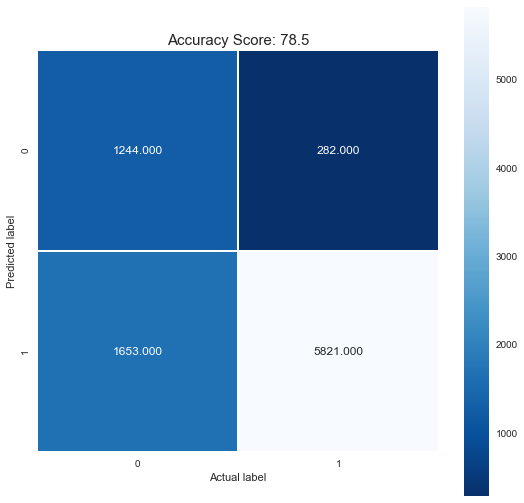


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |            78.5           |
|       Classification_error      |            21.5           |
|          True positive          |            5821           |
|          False positive         |            282            |
|          True negative          |            1244           |
|          False negative         |            1653           |
|        True positive rate       |     77.88332887342789     |
|       False negative rate       |     22.116671126572115    |
|        True negative rate       |     81.52031454783749     |
|       False positive rate       |     18.479685452162517    |
|         Precision value         |    

In [75]:
Confusion_metric(y_test,TF_pred,TF_acc)

<h3>Tuning the Hyper-parameters for finding the right alpha and gamma</h3>

In [76]:
%%time

#CODE FOR FINDING THE BEST HYPERPARAMETERS THROUGH GRIDSEARCH

TF_para=Grid_s(train_list_vector,y_tr,TEST_LIST_VECTOR,y_test)


The best model parameters for Gridsearch technique is  {'C': 1, 'gamma': 1}
The model score over the cv set is  0.8334444444444444
Wall time: 11min 59s


In [77]:

%%time
#CODE FOR FINDING THE BEST HYPERPARAMETERS USING RANDOMSEARCH
Rand_TF_para=Random_s(train_list_vector,y_tr,TEST_LIST_VECTOR,y_test)




The best model parameters for Randomsearch technique is  {'C': 0.8304998310063612, 'gamma': 0.41488323755969314}
The model score over the cv set is  0.8467777777777777
Wall time: 2min 25s


<h3>Testing the model over the test set using the optimal alpha and gamma.</h3>

In [79]:
tf_Pred,tf_accu=tuned_test(train_list_vector,y_tr,TEST_LIST_VECTOR,y_test,c=0.8304998310063612,gam= 0.41488323755969314)

The model score on train set is=  0.9774149659863945

The accuracy of svm over Test set is =  84% 


[[ 677  849]
 [ 530 6944]]


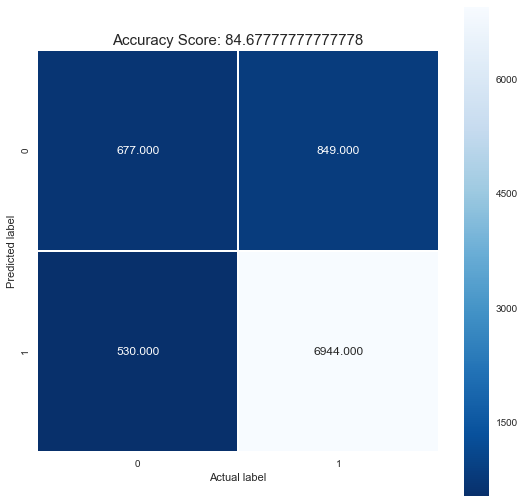


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     84.67777777777778     |
|       Classification_error      |     15.322222222222223    |
|          True positive          |            6944           |
|          False positive         |            849            |
|          True negative          |            677            |
|          False negative         |            530            |
|        True positive rate       |     92.90875033449291     |
|       False negative rate       |     7.091249665507091     |
|        True negative rate       |     44.36435124508519     |
|       False positive rate       |     55.63564875491481     |
|         Precision value         |    

In [80]:
Confusion_metric(y_test,tf_Pred,tf_accu)

<h3>Observations</h3>
<ul>
    <li>The test accuracy of the Kernel SVM model is 84.67% but it is miss-leading because after studying the confusion-matrix the model is not sensible.</li>
    <li>There is a serious bias problem as the majority points which are the positive reviews are dominating which leads to poor classiffication of the negative reviews.</li>
    <li>So here the Kernel SVM model fails to classify the reviews properly.</li>
    <li>Let's try the Linear SVM model for better accuracies.</li>

<h2>Implementing the TF-idf weighted word-2-vec over the 150k datapoints</h2>

In [112]:
SGD_list=li_xtr["CleanedText"]
test_list=li_xtest["CleanedText"]

Tfidf_tr,Tfidf_test=Tf_idf_vector(SGD_list,Tr_list,Tes_list,Model,Words)

73500
50
45000
50


<h3> Implementing the Linear SVM model and performing 10k-Crossvalidation over it.</h3>

--------------------------------------------------------------------------------------------------------
for alpha = 1e-05

the misclassification error for each alpha value is :  [0.201]
--------------------------------------------------------------------------------------------------------
for alpha = 0.0001

the misclassification error for each alpha value is :  [0.201 0.134]
--------------------------------------------------------------------------------------------------------
for alpha = 0.001

the misclassification error for each alpha value is :  [0.201 0.134 0.13 ]
--------------------------------------------------------------------------------------------------------
for alpha = 0.01

the misclassification error for each alpha value is :  [0.201 0.134 0.13  0.143]
--------------------------------------------------------------------------------------------------------
for alpha = 0.1

the misclassification error for each alpha value is :  [0.201 0.134 0.13  0.143 0.143]
-------

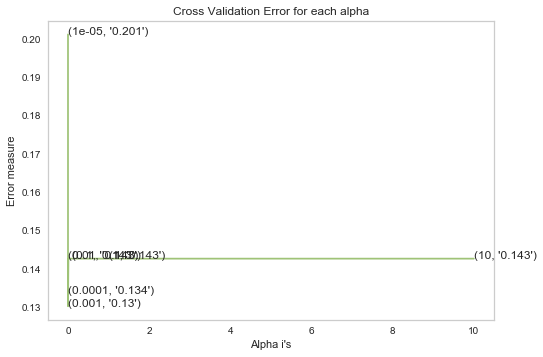

In [114]:
Cv_results(Tfidf_tr,li_ytr)

<h3>Testing the linear-SVM model over the test set by using the optimal alpha value.</h3> 

In [115]:
tfw2v_sgd_y,tfw2v_sgd_acc=linearsvm(Tfidf_test,li_ytest,0.001)


The accuracy of svm over Test set is =  85% 


[[ 398 1128]
 [ 137 7337]]


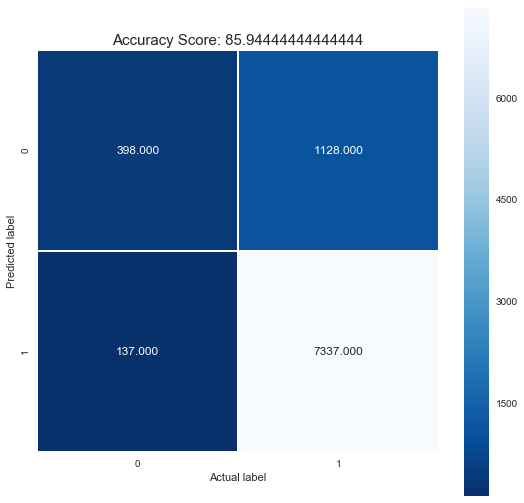


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification_accuracy     |     85.94444444444444     |
|       Classification_error      |     14.055555555555554    |
|          True positive          |            7337           |
|          False positive         |            1128           |
|          True negative          |            398            |
|          False negative         |            137            |
|        True positive rate       |     98.16697886004818     |
|       False negative rate       |     1.833021139951833     |
|        True negative rate       |     26.08125819134993     |
|       False positive rate       |     73.91874180865007     |
|         Precision value         |    

In [83]:
Confusion_metric(y_test,tfw2v_sgd_y,tfw2v_sgd_acc)

<h3>Observations</h3>
<ul>
    <li>The test accuracy of the linear SVM model is 85.94% but it is miss-leading because after studying the confusion-matrix the model is not sensible.</li>
    <li>There is a serious bias problem as the majority points which are the positive reviews are dominating which leads to poor classiffication of the negative reviews.</li>
    <li>So here the Linear SVM model also fails to classify the reviews properly.</li>

<h2>Conclusions</h2>

In [66]:
conclusion_table()


+---------------------------------------------------------------+
|    The comparisons of all the vectorizers are as follows:     |
+---------------------------+-------------+---------+-----------+
|         Vectorizer        |  Algorithm  |  Scores |   Status  |
+---------------------------+-------------+---------+-----------+
|        Bag-Of-Words       |  Kernel-SVM |  86.6%  |   Stable  |
|        Bag-Of-Words       |  Linear-SVM |  92.87% |   Stable  |
|           Tf-IDF          |  Kernel-SVM |  88.33% |   Stable  |
|           Tf-IDF          |  Linear-SVM |  89.82% |  Unstable |
|      Average-word2vec     |  Kernel-SVM |  85.91% |  Unstable |
|      Average-word2vec     |  Linear-SVM |  88.05% |  Unstable |
|  TF-IDF-Weighted-word2vec |  Kernel-SVM |  84.67% |  Unstable |
|  TF-IDF-Weighted-word2vec |  Linear-SVM |  85.94% |  Unstable |
+---------------------------+-------------+---------+-----------+


<ol>
    <li>From the above conclusion table the Linear SVM worked excellent with Bag-of-words & Tf-idf vectorizers and were also highly stable.</li>
    <li>The Kernel-SVM was also stable with the BOW nad tf-idf but still they are facing Bias problems.</li>
    <li>The gridearch and random search cross-validations are quite expensive interms of time and compute for larger datasets.
    <li>SGD with Linear-SVM was quite fast and have faster and good results.</li>
    <li>The Average and Tf-idf weighted word2vec were unstable even after tuning the hyperparameters in both Kernel and Linear SVM'S because of bias problems.</li>
    <li>So according to my observation I can Conclude that Linear model's are better in this case than Kernel-SVM's in case of BOW and Tf-idf vectorization techniques & Support Vector Machines are a good classification algorithm.</li>